### Aim of this assignment is to learn to implement semantic segmentation via Fully convolutional networks on a custom dataset

Complete the code marked with __###TO DO###__ followed with few instructions and hints

#### Requirements:
Pytorch  
PIL  
download  
zipfile  
matplotlib  
**install other modules as required

This notebook aims to implement Fully Convolutional Networks (FCN) on a custom bag dataset. Implementation FCN is of CVPR'15 Best Paper Honourable Mention award [Fully Convolutional Networks for Semantic Segmentation](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf) by Long et. al.  
The code is a forked version from following repository : https://github.com/wkentaro/pytorch-fcn


In [1]:
#import all required modules
from download import download
import zipfile
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset
import collections
import os
import torch
import torch.nn as nn
import argparse
import datetime
import pytz
import math
import tqdm
import torch.nn.functional as F
import shutil
import scipy
from google_drive_downloader import GoogleDriveDownloader as gdd
from torchvision import transforms

In [2]:
from fcn_utils import utils

### Step 1 :Handling Data
1. Visualize Data
2. Create CustomDataset Class
3. Create DataLoaders to create load data in batches

#### Download Data

In [3]:
#TODO after downloading delete the files 1.png and 2.png from the mask folder and name 0.png to 2.png and 0.jpg in JPEG images to 2.jpg

# download the bag dataset
url = "https://drive.google.com/file/d/1P4bdP6nSUOqQLhGXvZ1z4z3hNncJFrCs/view?usp=sharing"
gdd.download_file_from_google_drive(file_id='1P4bdP6nSUOqQLhGXvZ1z4z3hNncJFrCs',
                                    dest_path='./data/bags_data.zip',
                                    unzip=True)
#extract the dataset

path_to_zip_file = './data/bags_data.zip'
directory_to_extract_to = './data'
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

Analyze the "data/bags_data"  folder containing three subfolders. "JPEGImages" contain all the images of the dataset, "segmentation_mask" folder contains groundtruth corresponding to the given images.  Subfolder "imagesets" contains the train and validation split as text files "train.txt" and "val.txt"

In [3]:
!ls data/bags_data
!ls data/bags_data/imagesets/

imagesets  JPEGImages  segmentation_mask
train.txt  val.txt


### 1. Visualize the Data

Try visualizing other images and their labels of the given Dataset.

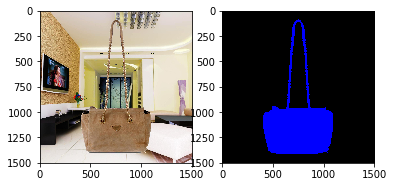

In [4]:
# visualizing an image in the dataset
image = PIL.Image.open('data/bags_data/JPEGImages/15.jpg')
label = PIL.Image.open('data/bags_data/segmentation_mask/15.png')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(label)

The above figure shows the image and segmentation mask of the bag. The aim is to train a FCN for segmenting bags in a given image.

#### 2. Create custom Dataset Class

In Pytorch, a custom dataset class is needed when our data is not in a standard data format, like Imagenet and CIFAR-10. This class can be used to load the training data for training any supervised or unsupervised model.

In pytorch this is done via **torch.utils.data.Dataset** class. Our Custom dataset class should inherit this class and override two methods. [Read more ...](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [5]:
### TO DO: Implement your own custom dataset class, which can be used to load train and validation images in batches.
### Hint: The given dataset is in standard VOC datset format, for which implemented Dataset class can be easily found on Internet
### You max refer to the original repository to get further help. 
class BagDataset(Dataset):
    mean_bgr = np.array([0.485, 0.456, 0.406])
    std_bgr = np.array([0.229, 0.224, 0.225])
    class_names = np.array([
        'background',
        'bag',
    ])
    #overridden function
    def __init__(self, root, split='train', transform=False):
        self.root = root
        self.split = split
        self._transform = transform
        dataset_dir = os.path.join(self.root, 'bags_data')
        self.files = collections.defaultdict(list)
        for split in ['train','val']:
            imgsets_file = os.path.join(dataset_dir, 'imagesets/%s.txt' % split)
            for did in  open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                label_file = os.path.join(dataset_dir, 'segmentation_mask/%s.png' % did)
                self.files[split].append({
                    'img' : img_file,
                    'lbl' : label_file
                })
    #overidden function
    def __len__(self):
        ###TO DO###
        '''
        Implement code to return the size of the dataset
        '''
        return len(self.files["train"]) + len(self.files["val"])

    #overridden function
    def __getitem__(self, index):
        index = index + 2 #Because of faulty dataset
        ###TO DO###
        '''
        Write code to load RGB image and label annotation image
        Resize both Images and labels to size 200x200 pixels for faster computation on Bag Dataset 
        '''
        toTensor = transforms.ToTensor()
        #TODO Images like 1.jpg do not exist!
        img = PIL.Image.open(os.path.join(self.root, 'bags_data', 'JPEGImages', str(index) + '.jpg'))
        img = np.array(img.resize((200,200)))
        lbl = PIL.Image.open(os.path.join(self.root, 'bags_data', 'segmentation_mask', str(index) + '.png'))
        lbl = np.array(lbl.resize((200,200)))
        
        if self._transform:
            img, lbl = self.transform(img, lbl)
            return img, lbl#toTensor(img), toTensor(lbl)
        else:
            return img, lbl#toTensor(img), toTensor(lbl)
                            
    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img /= self.std_bgr
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl
    
    @staticmethod
    def untransform(img, lbl):
        toPIL = transforms.ToPILImage()
        img, lbl = img, lbl#toPIL(img), toPIL(lbl)
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img *= BagDataset.std_bgr
        img += BagDataset.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        lbl = lbl.numpy()
        return img, lbl

#### 3. Create Dataloaders to load the data

In [6]:
root = os.path.expanduser('data') # use the path to parent dir of dataset
train_loader = torch.utils.data.DataLoader(
    BagDataset(root, split='train', transform=True),
    batch_size=1, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    BagDataset(root, split='val', transform=True),
    batch_size=1, shuffle=True)

**testing the loaders again, if we get expected image and labels**

In [7]:
import torchvision
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
image = torch.squeeze(images)
label = torch.squeeze(labels)
image, label = BagDataset.untransform(image, label)

In [8]:
def visualize_array(image, label):
    # visualizing numpy arrays of images and labels
    image = PIL.Image.fromarray(image)
    label = label.astype(dtype=np.uint8)
    label = PIL.Image.fromarray(label)
    label_color_indexed = label.convert('RGB').convert('L', palette=PIL.Image.ADAPTIVE, colors=2)
    label_color_indexed.putpalette([
    0, 0, 0, # index 0 is black backgroun
    0, 0, 255, # index 1 is blue 
    ])
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(label_color_indexed)

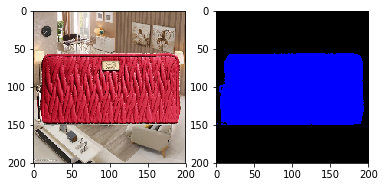

In [9]:
visualize_array(image, label)

### Step 2: Defining the Model

#### Defining the model architecture
Defining a model architrcture in Pytorch is straightforward using **nn.Module**. The custom model should always extend the class **nn.Module**, define model architecture in function **\_\_init\_\_()** and define the forward pass in function **forward()**. The backward pass need not to be explicitly defined, and is taken care by pytorch via its computational graph in forward pass. [Read more...](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-custom-nn-modules)

The simple changes required to convert a VGG16 model into a Fully Convolutional Networks are(For more details, please look into the paper):
1. Removing the fully connected layers and realizing them as convolutional layers
2. The Upsampling layer added at the end 

See __fcn32s.py__ file in __fc_model__ folder for further architecture implementation.

In [10]:
from fcn_models.fcn32s import FCN32s 
from fcn_models.fcn8 import FCN8s

### 3. Define Trainer:
This class defines methods to train and validate the network, generally it uses the data loaders, as created in Step 1, then compute the loss and call backward pass over the network to update the weights.

See __trainer.py__ for implementation

In [11]:
from trainer import Trainer

### 3. Define Training Method:
This is the main method which provides the dataloaders and the model to **Trainer** to train a network:

In [14]:
here = os.getcwd()
model = 'FCN32s'
#model = 'FCN8s'
#git_hash = git_hash()
gpu = 0
resume = None
max_iteration = 8001
lr = 1.0e-10
weight_decay = 0.0005
momentum = 0.99

now = datetime.datetime.now()
out = os.path.join(here, 'logs', now.strftime('%Y%m%d_%H%M%S.%f'))

os.makedirs(out)
# with open(os.path.join(out, 'config.yaml'), 'w') as f:
#    yaml.safe_dump(__dict__, f, default_flow_style=False)

os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
cuda = torch.cuda.is_available()

torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

# 1. dataset

root = os.path.expanduser('data')
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    BagDataset(root, split='train', transform=True),
    batch_size=1, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
    BagDataset(root, split='val', transform=True),
    batch_size=1, shuffle=False, **kwargs)

# 2. model

model = FCN32s(n_class=2)
#model = FCN8s(n_class=2)
start_epoch = 0
start_iteration = 0
if resume:
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']
else:
    vgg16 = torchvision.models.vgg16(pretrained=True)
    model.copy_params_from_vgg16(vgg16)
    print(model)
if cuda:
    model = model.cuda()

# 3. optimizer

optim = torch.optim.SGD(
    [
        {'params': get_parameters(model, bias=False)},
        {'params': get_parameters(model, bias=True),
         'lr': lr * 2, 'weight_decay': 0},
    ],
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)
if resume:
    optim.load_state_dict(checkpoint['optim_state_dict'])

trainer = Trainer(
    cuda=cuda,
    model=model,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=val_loader,
    out=out,
    max_iter=max_iteration,
    interval_validate=4000,
)
trainer.epoch = start_epoch
trainer.iteration = start_iteration
trainer.train()

FCN32s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

Train epoch=0:   0%|                                    | 0/534 [00:00<?, ?it/s]

Valid iteration=0:   0%|                                | 0/534 [00:00<?, ?it/s]

Valid iteration=0:   0%|                     | 1/534 [01:10<10:28:03, 70.70s/it]

Valid iteration=0:   0%|                      | 2/534 [01:33<8:16:21, 55.98s/it]

Valid iteration=0:   1%|                      | 3/534 [01:44<6:17:42, 42.68s/it]

Valid iteration=0:   1%|▏                     | 4/534 [01:49<4:38:36, 31.54s/it]

Valid iteration=0:   1%|▏                     | 5/534 [01:55<3:30:09, 23.84s/it]

Valid iteration=0:   1%|▏                     | 6/534 [02:00<2:40:49, 18.27s/it]

Valid iteration=0:   1%|▎                     | 7/534 [02:07<2:10:59, 14.91s/it]

Valid iteration=0:   1%|▎                     | 8/534 [02:13<1:45:24, 12.02s/it]

Valid iteration=0:   2%|▎                     | 9/534 [02:19<1:29:36, 10.24s/it]

Valid iteration=0:   2%|▍                    | 10/534 [02:24<1:17:13,  8.84s/it]

Valid iteration=

Valid iteration=0:  34%|███████▌              | 184/534 [17:48<37:55,  6.50s/it]

Valid iteration=0:  35%|███████▌              | 185/534 [17:53<35:02,  6.03s/it]

Valid iteration=0:  35%|███████▋              | 186/534 [17:58<32:34,  5.62s/it]

Valid iteration=0:  35%|███████▋              | 187/534 [18:02<30:50,  5.33s/it]

Valid iteration=0:  35%|███████▋              | 188/534 [18:07<29:42,  5.15s/it]

Valid iteration=0:  35%|███████▊              | 189/534 [18:12<28:41,  4.99s/it]

Valid iteration=0:  36%|███████▊              | 190/534 [18:16<28:05,  4.90s/it]

Valid iteration=0:  36%|███████▊              | 191/534 [18:21<27:30,  4.81s/it]

Valid iteration=0:  36%|███████▉              | 192/534 [18:26<27:18,  4.79s/it]

Valid iteration=0:  36%|███████▉              | 193/534 [18:31<27:49,  4.90s/it]

Valid iteration=0:  36%|███████▉              | 194/534 [18:36<27:26,  4.84s/it]

Valid iteration=0:  37%|████████              | 195/534 [18:40<27:11,  4.81s/it]

Valid iteration=

Valid iteration=0:  69%|███████████████▏      | 370/534 [33:21<12:56,  4.73s/it]

Valid iteration=0:  69%|███████████████▎      | 371/534 [33:26<12:52,  4.74s/it]

Valid iteration=0:  70%|███████████████▎      | 372/534 [33:31<12:59,  4.81s/it]

Valid iteration=0:  70%|███████████████▎      | 373/534 [33:36<12:52,  4.80s/it]

Valid iteration=0:  70%|███████████████▍      | 374/534 [33:41<12:50,  4.82s/it]

Valid iteration=0:  70%|███████████████▍      | 375/534 [33:46<12:45,  4.81s/it]

Valid iteration=0:  70%|███████████████▍      | 376/534 [33:51<12:52,  4.89s/it]

Valid iteration=0:  71%|███████████████▌      | 377/534 [33:56<12:59,  4.97s/it]

Valid iteration=0:  71%|███████████████▌      | 378/534 [34:00<12:43,  4.89s/it]

Valid iteration=0:  71%|███████████████▌      | 379/534 [34:05<12:31,  4.85s/it]

Valid iteration=0:  71%|███████████████▋      | 380/534 [34:10<12:25,  4.84s/it]

Valid iteration=0:  71%|███████████████▋      | 381/534 [34:15<12:13,  4.79s/it]

Valid iteration=

In [12]:
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        FCN32s, #FCN8s
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))


__Check the logs folder for visualizations of the results. Analyze log.csv to observe the mean iou score on validation data___

#### 5. Load the trained model and obtain predictions on validation or test data

In [21]:
###To DO###
'''
Write the code to load the trained model in variable "net", and set it to evaluation mode so predictions can be obtained.
'''
lr = 1.0e-10
weight_decay = 0.0005
momentum = 0.99
net = FCN32s(n_class=2)
#net = FCN8s(n_class=2)
optimizerEval = torch.optim.SGD(
    [
        {'params': get_parameters(net, bias=False)},
        {'params': get_parameters(net, bias=True),
         'lr': lr * 2, 'weight_decay': 0},
    ],
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)
#TODO specify the path accordingly to your own system
checkpoint = torch.load("./logs/20181201_143909.078664/model_best.pth.tar")
net.load_state_dict(checkpoint['model_state_dict'])
optimizerEval.load_state_dict(checkpoint['optim_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']
net.eval()

FCN32s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [22]:
def visualize_array_predicitons(image, label, prediction):
    # visualizing numpy arrays of images and labels
    image = PIL.Image.fromarray(image)
    label = label.astype(dtype=np.uint8)
    label = PIL.Image.fromarray(label)
    label_color_indexed = label.convert('RGB').convert('L', palette=PIL.Image.ADAPTIVE, colors=2)
    label_color_indexed.putpalette([
    0, 0, 0, # index 0 is black background
    0, 0, 255, # index 1 is blue 
    ])
    prediction = prediction.astype(dtype=np.uint8)
    prediction = PIL.Image.fromarray(prediction)
    prediction_color_indexed = prediction.convert('RGB').convert('L', palette=PIL.Image.ADAPTIVE, colors=2)
    prediction_color_indexed.putpalette([
    0, 0, 0, # index 0 is black backgroun
    0, 0, 255, # index 1 is blue 
    ])
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image)
    axarr[1].imshow(label_color_indexed)
    axarr[2].imshow(prediction_color_indexed)

In [23]:
dataiter = iter(val_loader)
images, labels = dataiter.next()
image_n = torch.squeeze(images)
label_n = torch.squeeze(labels)
image_n, label_n = BagDataset.untransform(image_n, label_n)

In [24]:
output = net(images)
lbl_pred = output.data.max(1)[1].cpu().numpy()[:, :, :]

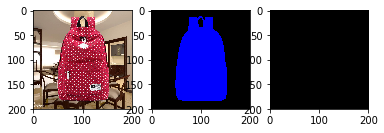

In [25]:
visualize_array_predicitons(image_n, label_n, lbl_pred[0])